In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import sklearn as sk
import powerlaw

## Function for Meander

In [2]:
clean_positions = "./data/clean_positions/"
ex_buoy = pd.read_csv(clean_positions + os.listdir(clean_positions)[0])

ex_buoy = ex_buoy.set_index("datetime")

def meander(data, *, window_hours=2, continuous=False):
    """
    Requires the data to be already gridded to hourly. Produces a dataframe of meander coefficients across time.
    The date index is the mid timestamp of each window.

    data: Containing x_stere and y_stere locations of buoy
    window: In the format of pandas timedelta (e.g. '1d')
    continuous: If True, calculate on sliding window, else calculates on non-overlapping groups
    """
    def lag_distances(lag=1):
        change_squared = ((data - data.shift(lag)).dropna()[["x_stere", "y_stere"]])**2
        dists = np.sqrt(change_squared["x_stere"] + change_squared["y_stere"]).dropna()

        dists.index = pd.to_datetime(dists.index)
        return dists

    straight_line = lag_distances(lag=window_hours)
    granular = lag_distances()

    granular_sums = granular.rolling(window_hours).sum().dropna()
    coefs = granular_sums/straight_line
    answer = pd.concat([coefs, granular_sums, straight_line], axis=1)
    answer.columns = ['meander', 'granular_sums', 'straight_line']

    if not continuous:
        answer = answer.resample(f"{window_hours}h")
        answer = answer.first()

    answer.index = answer.index - pd.DateOffset(hours=window_hours*1/2)

    return answer.dropna()

In [ ]:
clean_positions = "./data/clean_positions/"
a = []
b = []
for file in os.listdir(clean_positions)[:5]:
    buoy = pd.read_csv(clean_positions + file)
    buoy = buoy.set_index("datetime")
    m1 = meander(buoy, window_hours=24)

    buoy["x_stere"] += np.random.normal(scale=20, size=len(buoy))
    buoy["y_stere"] += np.random.normal(scale=20, size=len(buoy))
    m2 = meander(buoy, window_hours=24)

    a.append(m2["granular_sums"] - m1["granular_sums"])
    b.append(m2["straight_line"] - m1["straight_line"])

a = pd.concat(a)
b = pd.concat(b)

print(a.var(), b.var())

4199.53994880451 769.8303232161311


## Saving all the Meanders Files

In [3]:
output_path = "./data/daily_meanders/"
for file in os.listdir(clean_positions):
    ex_buoy = pd.read_csv(clean_positions + file)
    ex_buoy = ex_buoy.set_index("datetime")
    meander(ex_buoy, window_hours=24).to_csv(output_path + file)

## Loading the Daily Meanders

In [84]:
daily_meanders_folder = "./data/daily_meanders/"

meander_list = []
for file in os.listdir(daily_meanders_folder):
    meanders = pd.read_csv(daily_meanders_folder+file)
    meander_list.append(meanders)

m_df = pd.concat(meander_list)
#m_df = m_df[m_df["meander"] < 10]

m = m_df.reset_index(drop=True)["meander"]
inverse_m = 1 / m
print("Data points: ", len(m))

Data points:  181574


In [164]:
long_list = [i for i in meander_list if len(i)>10]
m_long = pd.concat(long_list).reset_index(drop=True)["meander"]

## Bounding Function
Only run this if you want to bound m_df by latitude and longitude

In [3]:
positions_folder = "./data/clean_positions/"
meander_folder = "./data/daily_meanders/"
meander_list = []

def bounding(lat_bounds, lon_bounds):
    for file in os.listdir(meander_folder):
        data = pd.read_csv(positions_folder+file)
        data = data.set_index("datetime")
        data.index = pd.to_datetime(data.index)

        lats = data["latitude"]
        lons = data["longitude"]

        lat_bounded = np.logical_and(lats > lat_bounds[0], lats < lat_bounds[1])
        lon_bounded = np.logical_and(lons > lon_bounds[0], lons < lon_bounds[1])
        bounded_mask = np.logical_and(lat_bounded, lon_bounded)
        
        if sum(bounded_mask) == 0:
            continue
        
        meander_data = pd.read_csv(meander_folder + file)
        meander_data = meander_data.set_index("datetime")
        meander_data.index = pd.to_datetime(meander_data.index)
        indices = meander_data.index.join(data.index, how="inner")

        meander_list.append(meander_data.loc[indices])
bounding([65,90], [-180,-160])
m_df = pd.concat(meander_list)

m = m_df.reset_index(drop=True)["meander"]
print("Data points: ", len(m))

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

## Basic Summary Stats

In [85]:
m.describe()

count    181574.000000
mean          1.620382
std           3.463472
min           1.000000
25%           1.023027
50%           1.091344
75%           1.373280
max         503.654185
Name: meander, dtype: float64

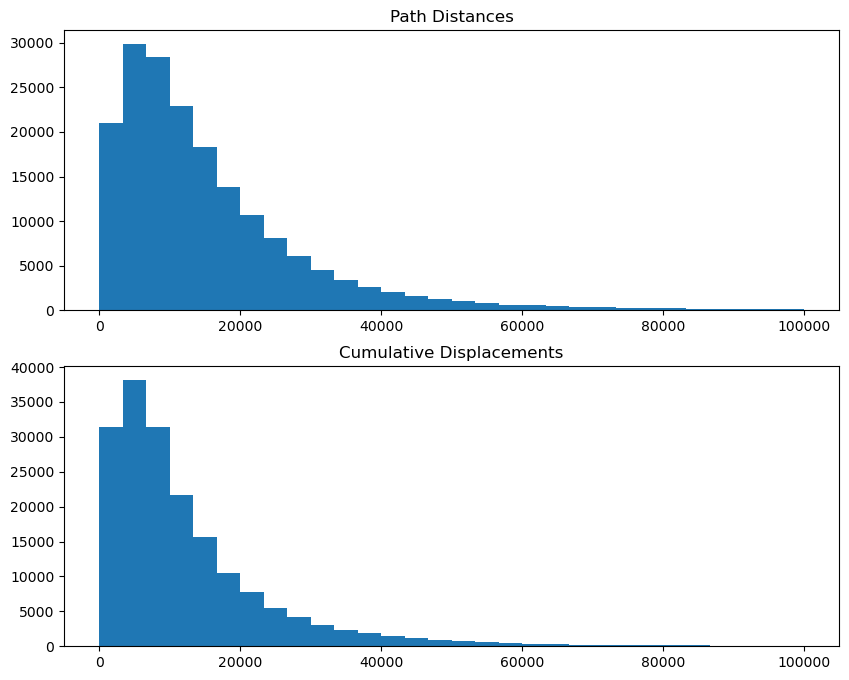

In [86]:
plt.figure(figsize=(10,8))
plt.tight_layout()
plt.subplot(2,1,1)
paths = m_df["granular_sums"]
plt.hist(paths[paths<10**5], bins=30)
plt.title("Path Distances")

plt.subplot(2,1,2)
displacements = m_df["straight_line"]
plt.title("Cumulative Displacements")
plt.hist(displacements[displacements<10**5], bins=30)

plt.show()

In [169]:
paths.min()

23.37212905381383

In [174]:
np.cov(paths, displacements)/np.mean(paths)/np.mean(displacements)

array([[2.22104266, 1.87908939],
       [1.87908939, 1.75194123]])

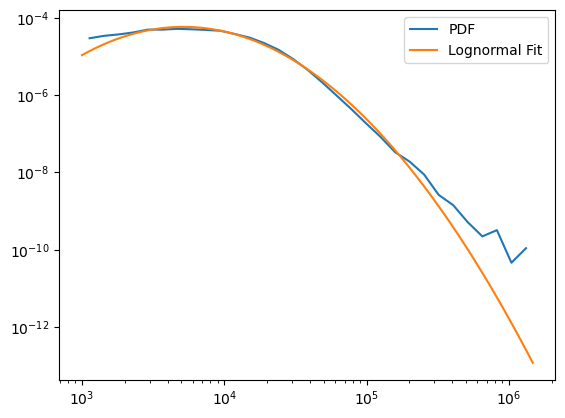

In [8]:
fit = powerlaw.Fit(paths, xmin=1000, fit_method="KS")

fit.plot_pdf(label="PDF")
fit.lognormal.plot_pdf(label="Lognormal Fit")

plt.legend()
plt.show()

## Express as a single underlying stochastic process

- Path length is the integral of speed over time
- All of the data is an approximation of the integral using a Riemann sum

- How does our typical median value and IQR of meander vary in time and space? Would help interpret satellite displacement

/home/alanxw/.micromamba/envs/ecco-sea-ice/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/home/alanxw/.micromamba/envs/ecco-sea-ice/lib/python3.9/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/home/alanxw/.micromamba/envs/ecco-sea-ice/lib/python3.9/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


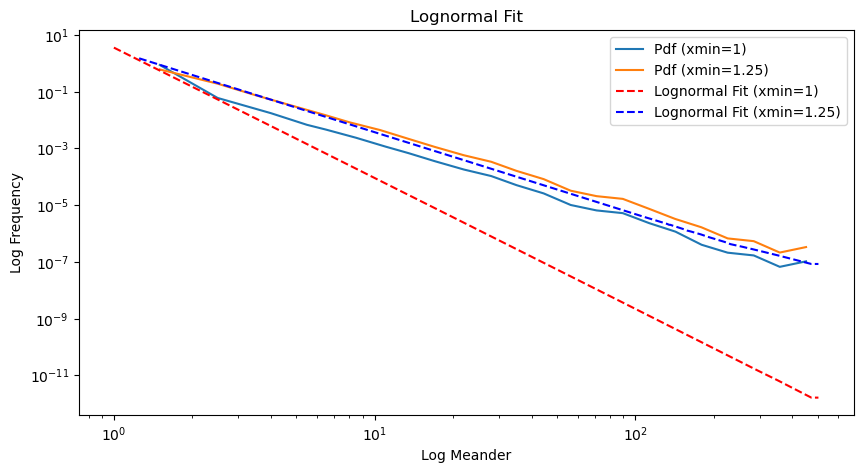

In [118]:
plt.figure(figsize=(10,5))

fit = powerlaw.Fit(data=m, xmin=1)
bounded_fit = powerlaw.Fit(data=m, xmin=1.25)

fit.plot_pdf(label="Pdf (xmin=1)")
bounded_fit.plot_pdf(label="Pdf (xmin=1.25)")

fit.lognormal.plot_pdf(color='r', linestyle='--', label='Lognormal Fit (xmin=1)')
bounded_fit.lognormal.plot_pdf(color='b', linestyle='--', label='Lognormal Fit (xmin=1.25)')

plt.title("Lognormal Fit")
plt.xlabel("Log Meander")
plt.ylabel("Log Frequency")

plt.legend()
plt.show()

/tmp/ipykernel_310631/2448489314.py:10: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(X[:-1]), np.log(freq))
Calculating best minimal value for power law fit
/home/alanxw/.micromamba/envs/ecco-sea-ice/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/home/alanxw/.micromamba/envs/ecco-sea-ice/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


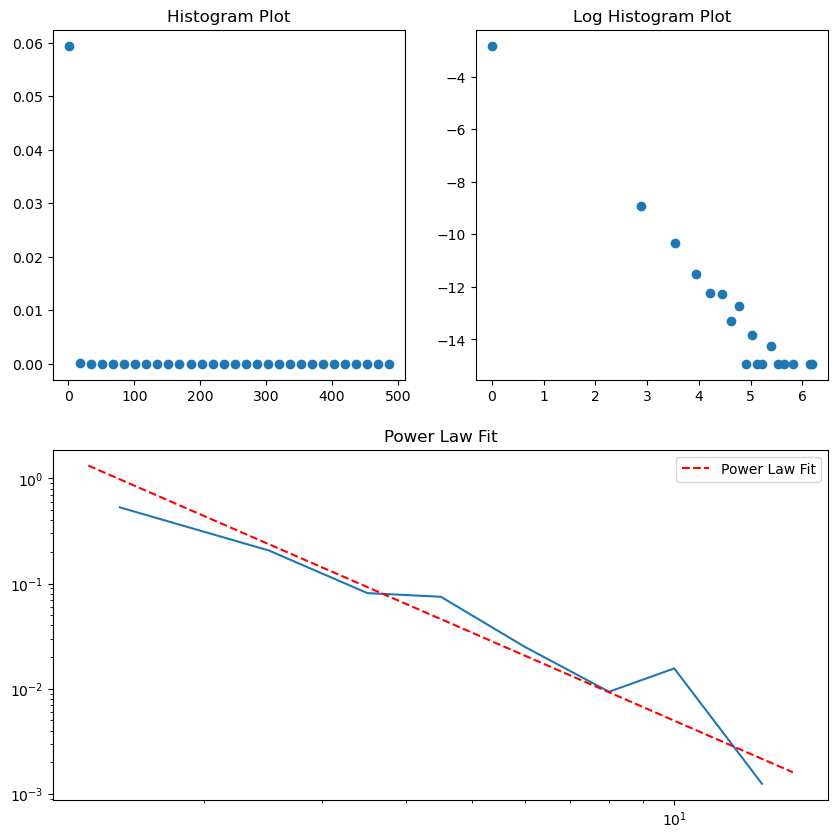

In [98]:
freq, X = np.histogram(m, density=True, bins=30)

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.scatter(X[:-1], freq)
plt.title("Histogram Plot")

plt.subplot(2,2,2)
plt.scatter(np.log(X[:-1]), np.log(freq))
plt.title("Log Histogram Plot")

fit = powerlaw.Fit(data=m[:500])

plt.subplot(2,1,2)
fit.plot_pdf()
fit.power_law.plot_pdf(color='r', linestyle='--', label='Power Law Fit')
plt.title("Power Law Fit")

plt.legend()
plt.show()

## Testing Various Distributions

In [96]:
from scipy.stats import beta, ks_1samp

In [92]:
alpha, beta_param, loc, scale = beta.fit(np.clip(inverse_m, 0+1e-10, 1-1e-7), floc=0, fscale=1)

In [97]:
ks_stat, p_value = ks_1samp(inverse_m, lambda x: beta.cdf(x, alpha, beta_param, loc, scale))
print(ks_stat, p_value)

0.08104296652875098 0.0


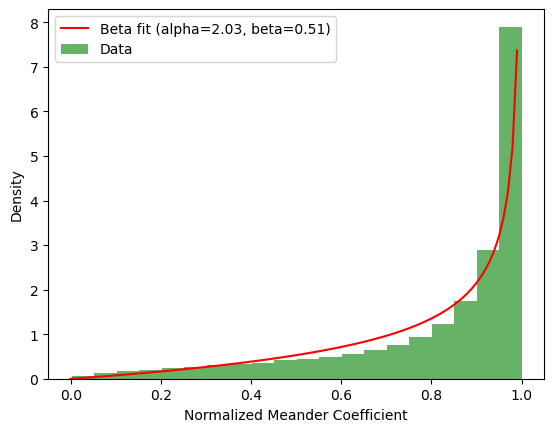

In [95]:
pdf_fitted = beta.pdf(np.linspace(0, 1, 100), alpha, beta_param, loc, scale)
plt.hist(inverse_m, bins=20, density=True, alpha=0.6, color='g', label='Data')
plt.plot(np.linspace(0, 1, 100), pdf_fitted, 'r-', label=f'Beta fit (alpha={alpha:.2f}, beta={beta_param:.2f})')
plt.xlabel('Normalized Meander Coefficient')
plt.ylabel('Density')
plt.legend()
plt.show()

In [77]:
# Implement Here
xmin_vals = np.linspace(1,2,100)

data_count = []
lognorm_ks_scores = []
powerlaw_ks_scores = []
truncated_ks_scores = []
weibull_ks_scores = []

for i in xmin_vals:
    data_count.append(np.sum(m>i))
    fit = powerlaw.Fit(m, xmin=i, fit_method="KS")
    #powerlaw_ks_scores.append(fit.power_law.D)
    #lognorm_ks_scores.append(fit.lognormal.D)
    #truncated_ks_scores.append(fit.truncated_power_law.D)
    #weibull_ks_scores.append(fit.stretched_exponential.D)

/home/alanxw/.micromamba/envs/ecco-sea-ice/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


/tmp/ipykernel_310631/4266107889.py:19: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(X[:-1]), np.log(freq))


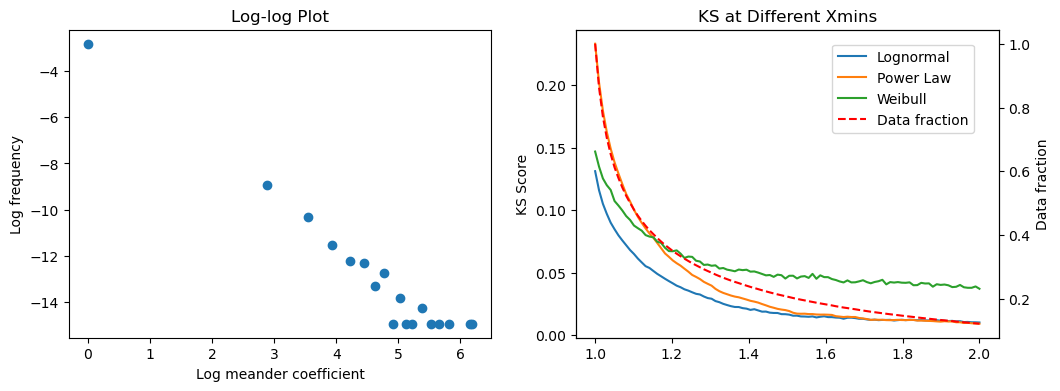

In [148]:
fig = plt.figure(figsize=(12,4))

ax = plt.subplot(1,2,2)
plt.plot(xmin_vals, np.load("lognormal_ks.npy"), label="Lognormal")
plt.plot(xmin_vals, np.load("powerlaw_ks.npy"), label="Power Law")
#plt.plot(xmin_vals, truncated_ks_scores, label="Truncated")
plt.plot(xmin_vals, np.load("weibull_ks.npy"), label="Weibull")
plt.ylabel("KS Score")

ax1 = ax.twinx()
plt.plot(xmin_vals, np.array(data_count)/len(m), label="Data fraction", linestyle="--", color="r")
plt.title("KS at Different Xmins")
plt.xlabel("Xmin")
plt.ylabel("Data fraction")

fig.legend(loc="upper right", bbox_to_anchor = (0.885, 0.86))

plt.subplot(1,2,1)
plt.scatter(np.log(X[:-1]), np.log(freq))
plt.title("Log-log Plot")
plt.xlabel("Log meander coefficient")
plt.ylabel("Log frequency")

plt.show()

### Check if lognormal is still lower with train test split
### Plan for e

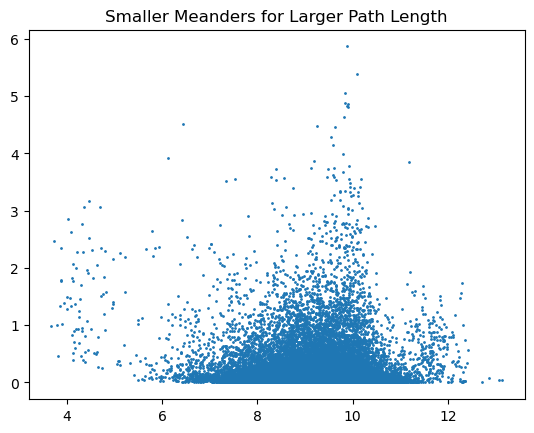

In [ ]:
plt.title("Smaller Meanders for Larger Path Length")
plt.plot(np.log(m_df["granular_sums"].values), np.log(m_df["meander"].values), marker='.', ms=2, lw=0)
plt.show()

## Autocorrelation

- Randomly selecting portions of paths up to a certain length
- Calculate autocorrelation for each of those
- Calculate ensemble average

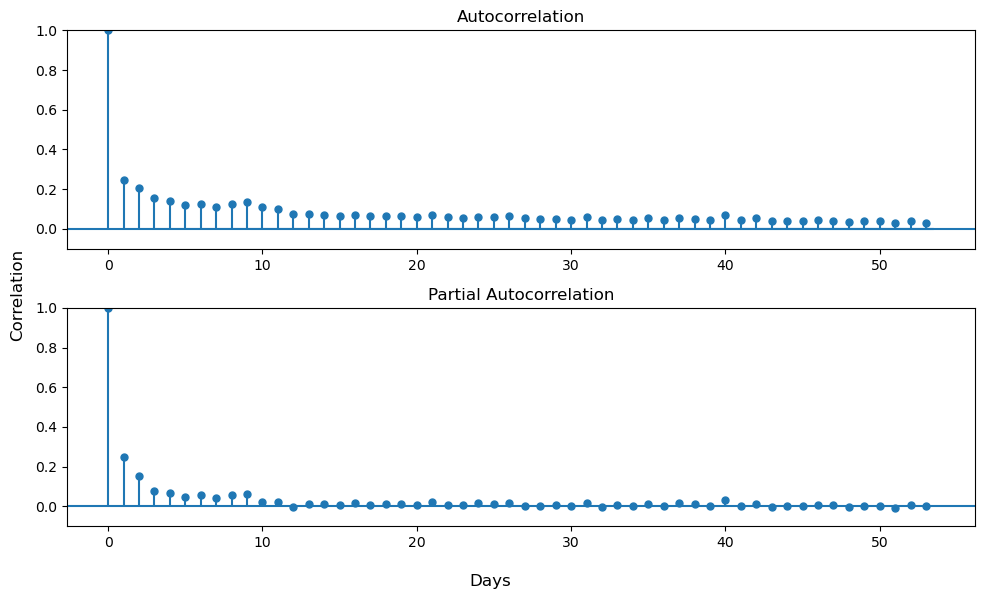

In [165]:
f = plt.figure(figsize=(10,6))
f.supxlabel("Days")
f.supylabel("Correlation")

l = plt.subplot(2,1,1)
plot_acf(m_long, ax=l)
l.set_ylim([-0.1, 1])

r = plt.subplot(2,1,2, sharex=l)
plot_pacf(m_long, ax=r)
r.set_ylim([-0.1, 1])

plt.tight_layout()
plt.show()

## Regressing the Path Distance Against Displacement

In [ ]:
import statsmodels.api as sm

X = m_df["straight_line"]
y = m_df["granular_sums"]
model = sm.OLS(y, X).fit()
nw_errors = model.get_robustcov_results(cov_type='HAC', maxlags=10)
display(nw_errors.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          granular_sums   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                              4333.
Date:                Thu, 14 Nov 2024   Prob (F-statistic):                        0.00
Time:                        10:19:06   Log-Likelihood:                     -2.7088e+05
No. Observations:               26777   AIC:                                  5.418e+05
Df Residuals:                   26776   BIC:                                  5.418e+05
Df Model:                           1                                                  
Covariance Type:                  HAC                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
straight_line     1.1640      0.018     65.827      0.000       1.129       1.199
==============================================================================
Omnibus:                    38912.669   Durbin-Watson:                   0.368
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         22780102.879
Skew:                           8.621   Prob(JB):                         0.00
Kurtosis:                     144.846   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 10 lags and without small sample correction
"""

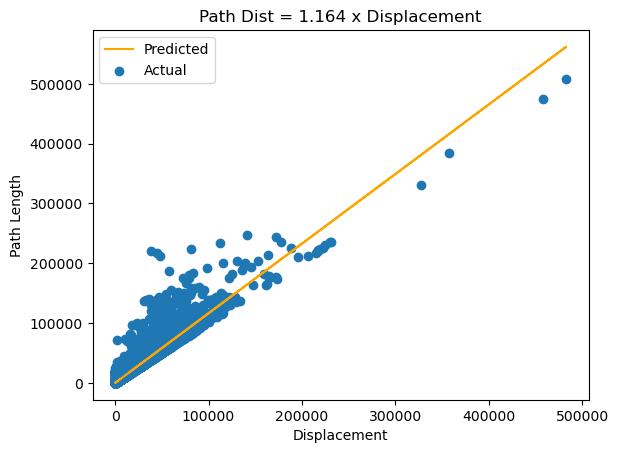

In [ ]:
plt.title(f"Path Dist = {round(model.params.values[0], 4)} x Displacement")
plt.scatter(X.values, y.values, label="Actual")
plt.plot(X.values, nw_errors.predict(X).values, color="orange", label="Predicted")
plt.xlabel("Displacement")
plt.ylabel("Path Length")
plt.legend()
plt.show()

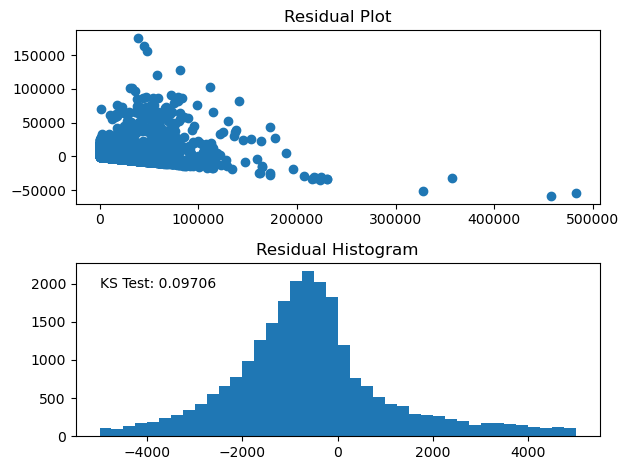

In [ ]:
from scipy.stats import kstest

plt.subplot(2,1,1)
plt.scatter(X.values, model.resid.values)
plt.title("Residual Plot")
plt.subplot(2,1,2)

resids = model.resid[np.logical_and(model.resid < 5000, model.resid>-5000)]
hist = plt.hist(resids, bins=40)
print()
plt.title("Residual Histogram")
mean, std = resids.mean(), resids.std()
plt.text(min(resids.values), max(hist[0])*0.9, f"KS Test: {round(kstest(resids, 'norm', args=(mean, std)).statistic, 5)}")

plt.tight_layout()
plt.show()

## Direct Newey West

In [ ]:
n = len(m)

X = sm.add_constant(np.zeros(n))
y = m

model = sm.OLS(y, X).fit()

newey_west_cov = model.get_robustcov_results(cov_type='HAC', maxlags=10).cov_params()
autocorr_adjusted_variance = np.diag(newey_west_cov)

print("Autocorrelation-Adjusted Variance:\n", autocorr_adjusted_variance)

Autocorrelation-Adjusted Variance:
 [0.00203143 0.        ]


## Grouping by Season
- Group by month as well, figure out if the variation in months is captured by seasons
- Polish this into a Google Doc for the ECCO paper

In [53]:
import statsmodels.api as sm

def assign_season(date):
    # Define season start and end dates for 2023 (adjust if necessary)
    if (date >= pd.Timestamp('2023-03-20') and date <= pd.Timestamp('2023-06-20')):
        return 'Spring'
    elif (date >= pd.Timestamp('2023-06-21') and date <= pd.Timestamp('2023-09-22')):
        return 'Summer'
    elif (date >= pd.Timestamp('2023-09-23') and date <= pd.Timestamp('2023-12-21')):
        return 'Autumn'
    else:
        return 'Winter'

,Autumn,Spring,Summer,Winter
count,14323.000000,7758.000000,10627.000000,148866.000000
mean,1.385589,1.371939,1.816276,1.641935
std,1.645507,1.561133,5.216199,3.505694
min,1.000042,1.000097,1.000127,1.000000
25%,1.014081,1.016030,1.049982,1.023691
50%,1.051644,1.060605,1.189228,1.093759
75%,1.212972,1.234234,1.674459,1.379504
max,63.326005,48.408824,472.993303,503.654185
Regression Estimate,1.166859,1.067034,1.047299,1.070426
Regression SE,0.045394,0.025053,0.017665,0.010008


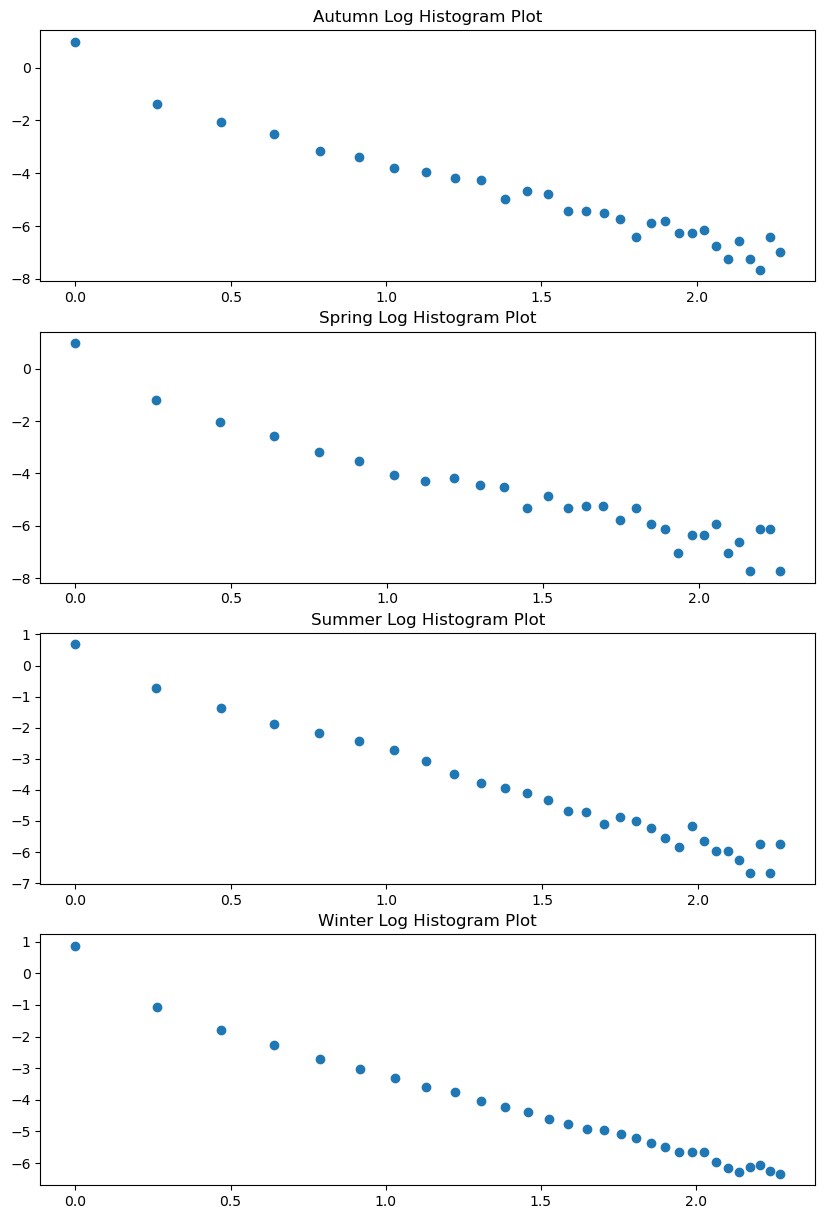

In [54]:
groups = m_df.reset_index()
groups["datetime"] = pd.to_datetime(groups["datetime"])
groups["season"] = groups["datetime"].apply(assign_season)
groups = groups.groupby("season")

m = m_df.reset_index(drop=True)["meander"]

season_dfs = []
plt.figure(figsize=(10,15))
plt.tight_layout()
for i, (season, data) in enumerate(groups):
    group_m = data.reset_index(drop=True)["meander"]
    group_m = group_m[group_m<10]
    
    freq, X = np.histogram(group_m, density=True, bins=30)


    plt.subplot(4,1,i+1)
    plt.scatter(np.log(X[:-1][freq!=0]), np.log(freq[freq!=0]))
    plt.title(f"{season} Log Histogram Plot")

    X = data["straight_line"]
    X = X - X.mean()
    y = data["granular_sums"]
    model = sm.OLS(y, X).fit()
    nw_errors = model.get_robustcov_results(cov_type='HAC', maxlags=10)
    renamed_meander = data["meander"].rename(f"{season}").describe()
    renamed_meander.loc["Regression Estimate"] = nw_errors.params[0]
    renamed_meander.loc["Regression SE"] = nw_errors.bse[0]
    season_dfs.append(renamed_meander)
    
display(pd.concat(season_dfs, axis=1))

<BarContainer object of 4 artists>

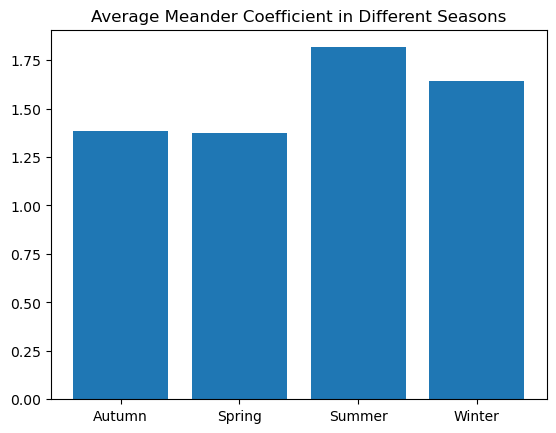

In [64]:
d = pd.concat(season_dfs, axis=1).T["mean"]
plt.title("Average Meander Coefficient in Different Seasons")
plt.bar(d.index, d)

## Uncertainty propagation
- Some meander coefficients have too much uncertainty to be considered for the average
- Total displacement for a day requires two points, confidence in distance traveled goes down as distance goes further apart
- For total path length, uncertainty goes up with each extra segment
- Figure out what the standard deviation of the buoy tech is and how that propagates into path distance and total path length
- It should be okay to assume that errors are uncorrelated at hourly time scale
- Given a meander coefficient that has uncertainty

## Getting the pdf of the meander coefficient distribution
- Getting the distribution of the two terms in the meander coefficient
    - We know the meander coefficient is autocorrelated (mean is the same)
    - Is the histogram of autocorrelated data affected?
        - Does the pdf depend on autocorrelation?
    - Estimating what the autocorrelation structure is for more buoys
        - Estimate mean and autocorrelation-adjusted variance
    - Integral timescale on acf (until first zero cross)

Time Series Analysis: Box et al.
